 # Data_Preprocessing


In [ ]:
# General Imports
import io
import numpy as np
import pandas as pd
import pickle
from os.path import join

# Text Processing Imports
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gpp
import gensim.utils as gu
import nltk
nltk.download('wordnet')  # Downloading the wordnet data for lemmatization

 # For character encoding detection
import chardet

 # For KNN imputation of missing data
from sklearn.impute import KNNImputer

[nltk_data] Downloading package wordnet to /root/nltk_data...


#Loading Data

The code below creates a function that reads files(three csvs) and combine them to get a new "combined dataset"


In [ ]:
def combine_data(file_paths):
    """
    Combine data from multiple CSV files into a single DataFrame.

    Args:
        file_paths (list): A list of file paths to the CSV files to be combined.

    Returns:
        pandas.DataFrame: The combined DataFrame containing data from all input files.
    """
    dfs = []
    encodings = ['utf-8', 'ISO-8859-1', 'windows-1252']

    for i, file_path in enumerate(file_paths):
        success = False
        for enc in encodings:
            try:
                if i == 0:
                    # Read the first file to get column names
                    df = pd.read_csv(file_path, encoding=enc, low_memory=False)
                    col_names = df.columns
                else:
                    # Read the subsequent files using the column names from the first file
                    df = pd.read_csv(file_path, encoding=enc, low_memory=False, names=col_names)
                success = True
                break
            except UnicodeDecodeError:
                continue

        if not success:
            print(f"Failed to read {file_path} with any of the provided encodings.")
            return

        dfs.append(df)

    # Concatenate all DataFrames in the list into a single combined DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


In [ ]:
# Provide a list of file paths to the CSV files you want to combine
file_paths = ['Data/sentiment.csv', 'Data/Equal.csv', 'Data/RATIO.csv']

# Call the function with the correct file_paths list
combined_data = combine_data(file_paths)
combined_data.shape

(312304, 6)

In [ ]:
sentiment= pd.read_csv("sentiment.csv",encoding='unicode_escape')
sentiment.shape

<ipython-input-4-9741270c6858>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment= pd.read_csv("sentiment.csv",encoding='unicode_escape')


(171380, 6)

In [ ]:
equal= pd.read_csv("Equal.csv",encoding='ISO-8859-1')
equal.shape

(76704, 6)

In [ ]:
ratio= pd.read_csv("RATIO.csv",encoding='ISO-8859-1')
ratio.shape

(64218, 6)

#Create functions for textual data cleaning

In [ ]:
def preprocess_text(text):
    """Preprocesses a given string text input this removes the following """
    preprocs = [
        gpp.strip_tags,
        gpp.strip_punctuation,
        gpp.strip_multiple_whitespaces,
        gpp.strip_numeric,
        gpp.remove_stopwords,
        gpp.strip_short,
    ]
    text = gu.to_unicode(text.lower().strip())
    for preproc in preprocs:
        text = preproc(text)
    return text

def lemmatize(text):
    """Lemmatizes a given string text input"""
    wnl = WordNetLemmatizer()
    return wnl.lemmatize(text)




# combining the above two functions
preprocess = lambda text: lemmatize(preprocess_text(str(text)))

In [ ]:
cleaned= sentiment

# Create function for numerical data extraction

In [ ]:
def extract_numerical_from_column(dataframe, column_name):
    """
    Extract numerical values from a specific column of a pandas DataFrame using str.extract('(\d+)').

    Args:
        dataframe (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to extract numerical values from.

    Returns:
        pandas.Series: A new Series with extracted numerical values.
    """
    # Ensure dataframe is a pandas DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input 'dataframe' must be a pandas DataFrame.")

    # Check if the specified column exists in the DataFrame
    if column_name not in dataframe.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Extract numerical values from the specified column
    extracted_data = dataframe[column_name].str.extract('(\d+)')

    return extracted_data

#Combine review and summary together

In [ ]:
combined_data["ReviewFull"] = combined_data["Summary"] + " " + combined_data["Review"]
combined_data = combined_data.drop(["Summary", "Review"], axis=1)

In [ ]:
sentiment["ReviewFull"] = sentiment["Summary"] + " " + sentiment["Review"]
sentiment = sentiment.drop(["Summary", "Review"], axis=1)

#Creating a fuction that takes in multiple columns and apply text cleaning on them


In [ ]:
# this function takes a list of columns in the data frame and perform text process for each column in the list
def preprocess_columns(data, columns):
  for column in columns:
    data[column] = data[column].apply(preprocess)

  return data

columns_names=["ProductName","ReviewFull","Sentiment"]


sentiment= preprocess_columns(sentiment,columns_names)
sentiment.head()



,ProductName,ProductPrice,Rate,Sentiment,ReviewFull
0,candes room personal air cooler white black el...,3999,5,positive,great cooler excellent air flow price amazing ...
1,candes room personal air cooler white black el...,3999,5,positive,best budget fit cooler nice cooling awesome
2,candes room personal air cooler white black el...,3999,3,positive,quality good power air decent fair
3,candes room personal air cooler white black el...,3999,1,negative,bad product fan useless product
4,candes room personal air cooler white black el...,3999,3,neutral,product fair


#Function to show us missing values

In [ ]:
def print_missing_rows(data):
    """
    Print rows with missing values for each column in a DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame to analyze.
    """
    for column in data.columns:
        missing_rows = data[data[column].isnull()]
        if not missing_rows.empty:
            print(f"Missing values in '{column}':")
            print(missing_rows)
            print("\n")
    return data


In [ ]:
missing_sentiment=print_missing_rows(sentiment)
sentiment[sentiment["Sentiment"].isnull()].sum()

Missing values in 'ProductPrice':
       ProductName ProductPrice Rate Sentiment ReviewFull
171379                      NaN  NaN       nan        nan


Missing values in 'Rate':
       ProductName ProductPrice Rate Sentiment ReviewFull
171379                      NaN  NaN       nan        nan




ProductName     0.0
ProductPrice    0.0
Rate            0.0
Sentiment       0.0
ReviewFull      0.0
dtype: float64

In [ ]:


# Calculate the number of rows before handling missing values
rows_before = len(sentiment)

# Calculate the number of rows after handling missing values
sentiment_cleaned = sentiment.dropna(subset=['ReviewFull'])
rows_after = len(sentiment_cleaned)

# Find the dropped rows
dropped_rows = sentiment[~sentiment.index.isin(sentiment_cleaned.index)]

# Display the dropped rows
print("Dropped Rows:")
print(dropped_rows)
print(rows_after)

Dropped Rows:
Empty DataFrame
Columns: [ProductName, ProductPrice, Rate, Sentiment, ReviewFull]
Index: []
171380


In [ ]:
missing_reviews_count = sentiment['ReviewFull'].isna().sum()
missing_reviews_count
sentiment.shape

(171380, 5)

#Filtering row with empyt or null Reviews

In [ ]:
combined_data.replace(['nan', ''], np.nan, inplace=True)
combined_data = combined_data.dropna(subset=['ReviewFull'])



In [ ]:
sentiment.replace(['nan', ''], np.nan, inplace=True)
sentiment = sentiment.dropna(subset=['ReviewFull'])

In [ ]:
sentiment.shape
#(171380, 6)


(170952, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Perfoming Numeric Exrtraction on Price

In [ ]:
extract_numerical_from_column(combined_data, "ProductPrice")
#print(combined_data.ProductPrice.value_counts())


#Now we will impute the messing price value



1.   By looking at the price of a same produc_name
2.   If we have only review for that product we use knn



In [ ]:
def replace_missing_price(df):
    """
    Replace missing prices in a DataFrame.

    If a product with a missing price appears multiple times in the database, the missing price is replaced
    with the price from another row (if available).

    If the product appears only once and its price is missing, k-Nearest Neighbors is used to predict the missing price.

    Args:
    - df (pd.DataFrame): The DataFrame with the products and prices.

    Returns:
    - pd.DataFrame: The DataFrame with missing prices replaced.
    """

    # Step 1: Replace missing prices with prices from other rows for the same product
    no_missing_prices = df.dropna(subset=['ProductPrice'])
    missing_prices = df[df['ProductPrice'].isnull()]

    for idx, row in missing_prices.iterrows():
        possible_prices = no_missing_prices[no_missing_prices['ProductName'] == row['ProductName']]['ProductPrice']
        if not possible_prices.empty:
            df.at[idx, 'ProductPrice'] = possible_prices.iloc[0]

    # Step 2: Use kNN for remaining missing prices
    missing_prices = df[df['ProductPrice'].isnull()]

    if not missing_prices.empty:
        imputer = KNNImputer(n_neighbors=5)

        columns_to_use = df[['Rate']]

        imputed = imputer.fit_transform(columns_to_use)
        df['ProductPrice'] = imputed[:, 0]

    return df
    # string maTCH FOR PRICE IMPATTION
    # A LIMIATION DID IMPATAION TO PRICE

In [ ]:
replace_missing_price(combined_data)

#Rate preprocessing
now we look at rate column and only allow 1,2,3,4 or 5 Ratring
if the column has other value i.e missng,string etc it will be converted null
then imputaion will carried out fill the null values

if the row with missing rate is only one product use knn other wise look at the same product rating and perform mode imputaion

In [ ]:
# Convert all non-integer values to NaN
def filter_ratings(value):
    try:
        if float(value).is_integer():
            return int(value)
        else:
            return None
    except:
        return None

combined_data['Rate'] = combined_data['Rate'].apply(filter_ratings)

def impute_rating_mode(group):
    # If there are missing ratings in this group
    if group['Rate'].isnull().any():
        mode_values = group['Rate'].mode()

        # Check if mode_values is not empty
        if not mode_values.empty:
            most_common_rating = mode_values.iloc[0]
            group['Rate'].fillna(most_common_rating, inplace=True)
    return group

# Apply the function to each product group
combined_data = combined_data.groupby('ProductName').apply(impute_rating_mode)

# For products with a single missing review, use KNN
single_products_mask = combined_data['ProductName'].duplicated(keep=False) == False
single_missing_mask = combined_data['Rate'].isnull()

# Subset of single instance products with missing rating
subset_for_knn = combined_data[single_products_mask & single_missing_mask]

if not subset_for_knn.empty:
    # Initialize KNN imputer
    imputer = KNNImputer(n_neighbors=5)

    # Using only rating value for KNN imputation
    imputed_values = imputer.fit_transform(combined_data[['Rate']])

    # Convert non-integer values to NaN
    imputed_values = [int(value) if float(value).is_integer() else None for value in imputed_values]

    # Update the combined_data DataFrame with the imputed values
    combined_data.loc[:, 'Rate'] = imputed_values




# Removing rows that does not have positive negative or neural

beacuse these are the lables we can't impute them because they important piece of information and has to be accurate

In [ ]:
unique_count_a = sentiment['Sentiment'].unique()
print(unique_count_a)

['positive' 'negative' 'neutral']


In [ ]:
#filtering that rows that are not prositive , negative or neurtal
combined_data = combined_data[combined_data['Sentiment'].isin(['positive', 'negative', 'neutral'])]
combined_data.Sentiment.value_counts()

In [ ]:

sentiment  = sentiment[sentiment['Sentiment'].isin(['positive', 'negative', 'neutral'])]
sentiment.Sentiment.value_counts()
sentiment.shape

(171379, 5)

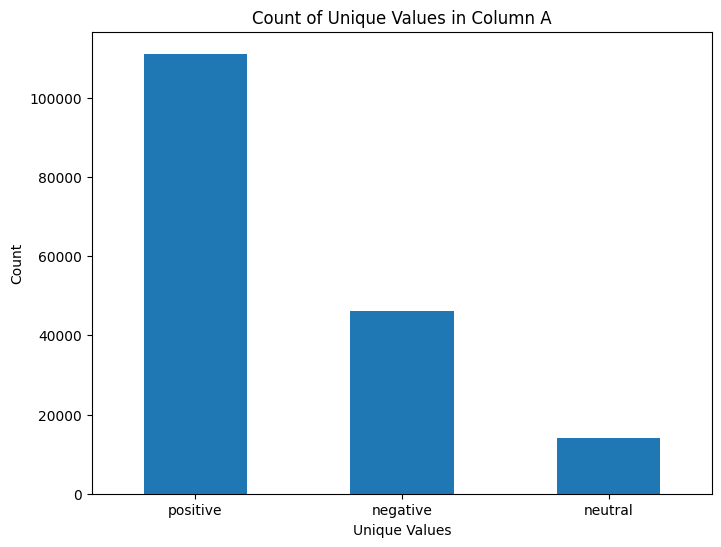

In [ ]:
import matplotlib.pyplot as plt
# Count of unique values in column 'A'
w

5.0    80136
1.0    32987
4.0    27804
3.0    19783
2.0    10668
Name: Rate, dtype: int64


<ipython-input-22-7258eaa886a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment['Rate'] = pd.to_numeric(sentiment['Rate'], errors='coerce')


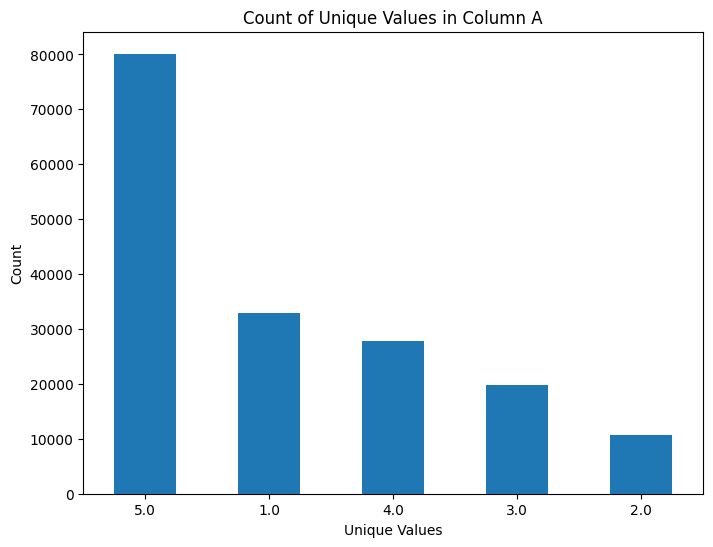

In [ ]:
sentiment['Rate'] = pd.to_numeric(sentiment['Rate'], errors='coerce')
sentiment = sentiment.dropna(subset=['Rate'])
sentiment['ProductPrice'] = pd.to_numeric(sentiment['ProductPrice'], errors='coerce')
sentiment = sentiment.dropna(subset=['ProductPrice'])

# Check the values again
value_counts = sentiment['Rate'].value_counts()
print(value_counts)
# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Column A')
plt.xticks(rotation=0)
plt.show()

In [ ]:
sentiment['ProductPrice'] = pd.to_numeric(sentiment['ProductPrice'], errors='coerce')
sentiment = sentiment.dropna(subset=['ProductPrice'])
product=sentiment.ProductPrice.value_counts()
product

218.0      6999
449.0      5234
1599.0     4257
13999.0    3205
499.0      3186
           ... 
3049.0        2
292.0         1
263.0         1
4380.0        1
368.0         1
Name: ProductPrice, Length: 438, dtype: int64

In [ ]:
value_counts = sentiment.Rate.value_counts()
value_counts

5                                                               56717
1                                                               28338
5.0                                                             23419
4                                                               19619
3                                                               16909
2                                                                9488
4.0                                                              8185
1.0                                                              4649
3.0                                                              2874
2.0                                                              1180
Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)        1
Name: Rate, dtype: int64

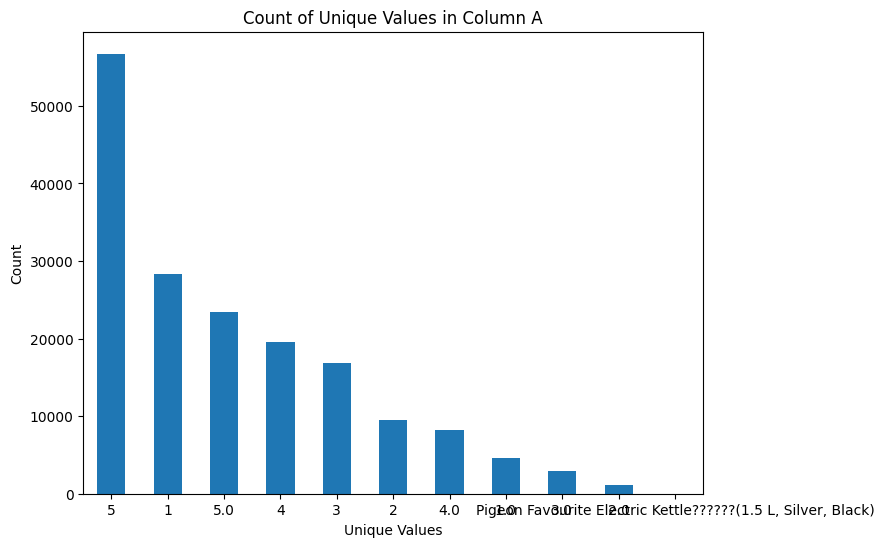

In [ ]:
value_counts = sentiment.Rate.value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Column A')
plt.xticks(rotation=0)
plt.show()

In [ ]:
sentiment

# Now we convert the Sentiment value to 0,1,-1 accordigly

In [ ]:
sentiment_map = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

# Replace the sentiments with the corresponding numerical values
combined_data['Sentiment'] = combined_data['Sentiment'].replace(sentiment_map)
combined_data.head()

#Finally we save our filtered data

In [ ]:
combined_data.to_csv('cleaned_data.csv', index=False)


In [ ]:
sentiment.to_csv('cleaned_data.csv', index=False)

In [ ]:
combined_data.shape